In [1]:
import pandas as pd
import numpy as np
import os
import gensim
import matplotlib.pyplot as plt
from many_stop_words import get_stop_words
import opencorpora
from pymystem3 import Mystem
from scipy.spatial.distance import cosine
import seaborn as sns
%matplotlib inline
ru_stopwords = get_stop_words('ru')

In [2]:
reader = opencorpora.CorpusReader('data/opencorpora/annot.opcorpora.xml')
stem = Mystem(entire_input=False)

In [3]:
docs = [list(filter(lambda token: token not in ru_stopwords, stem.lemmatize(doc))) for doc in reader.iter_raw_sents()]

In [4]:
import tf_glove
model = tf_glove.GloVeModel(embedding_size=100, context_size=10, min_occurrences=25,
                            learning_rate=0.05, batch_size=512)

In [5]:
model.fit_to_corpus(docs)

In [6]:
model.train(num_epochs=50, summary_batch_interval=500)

Модель русского языка

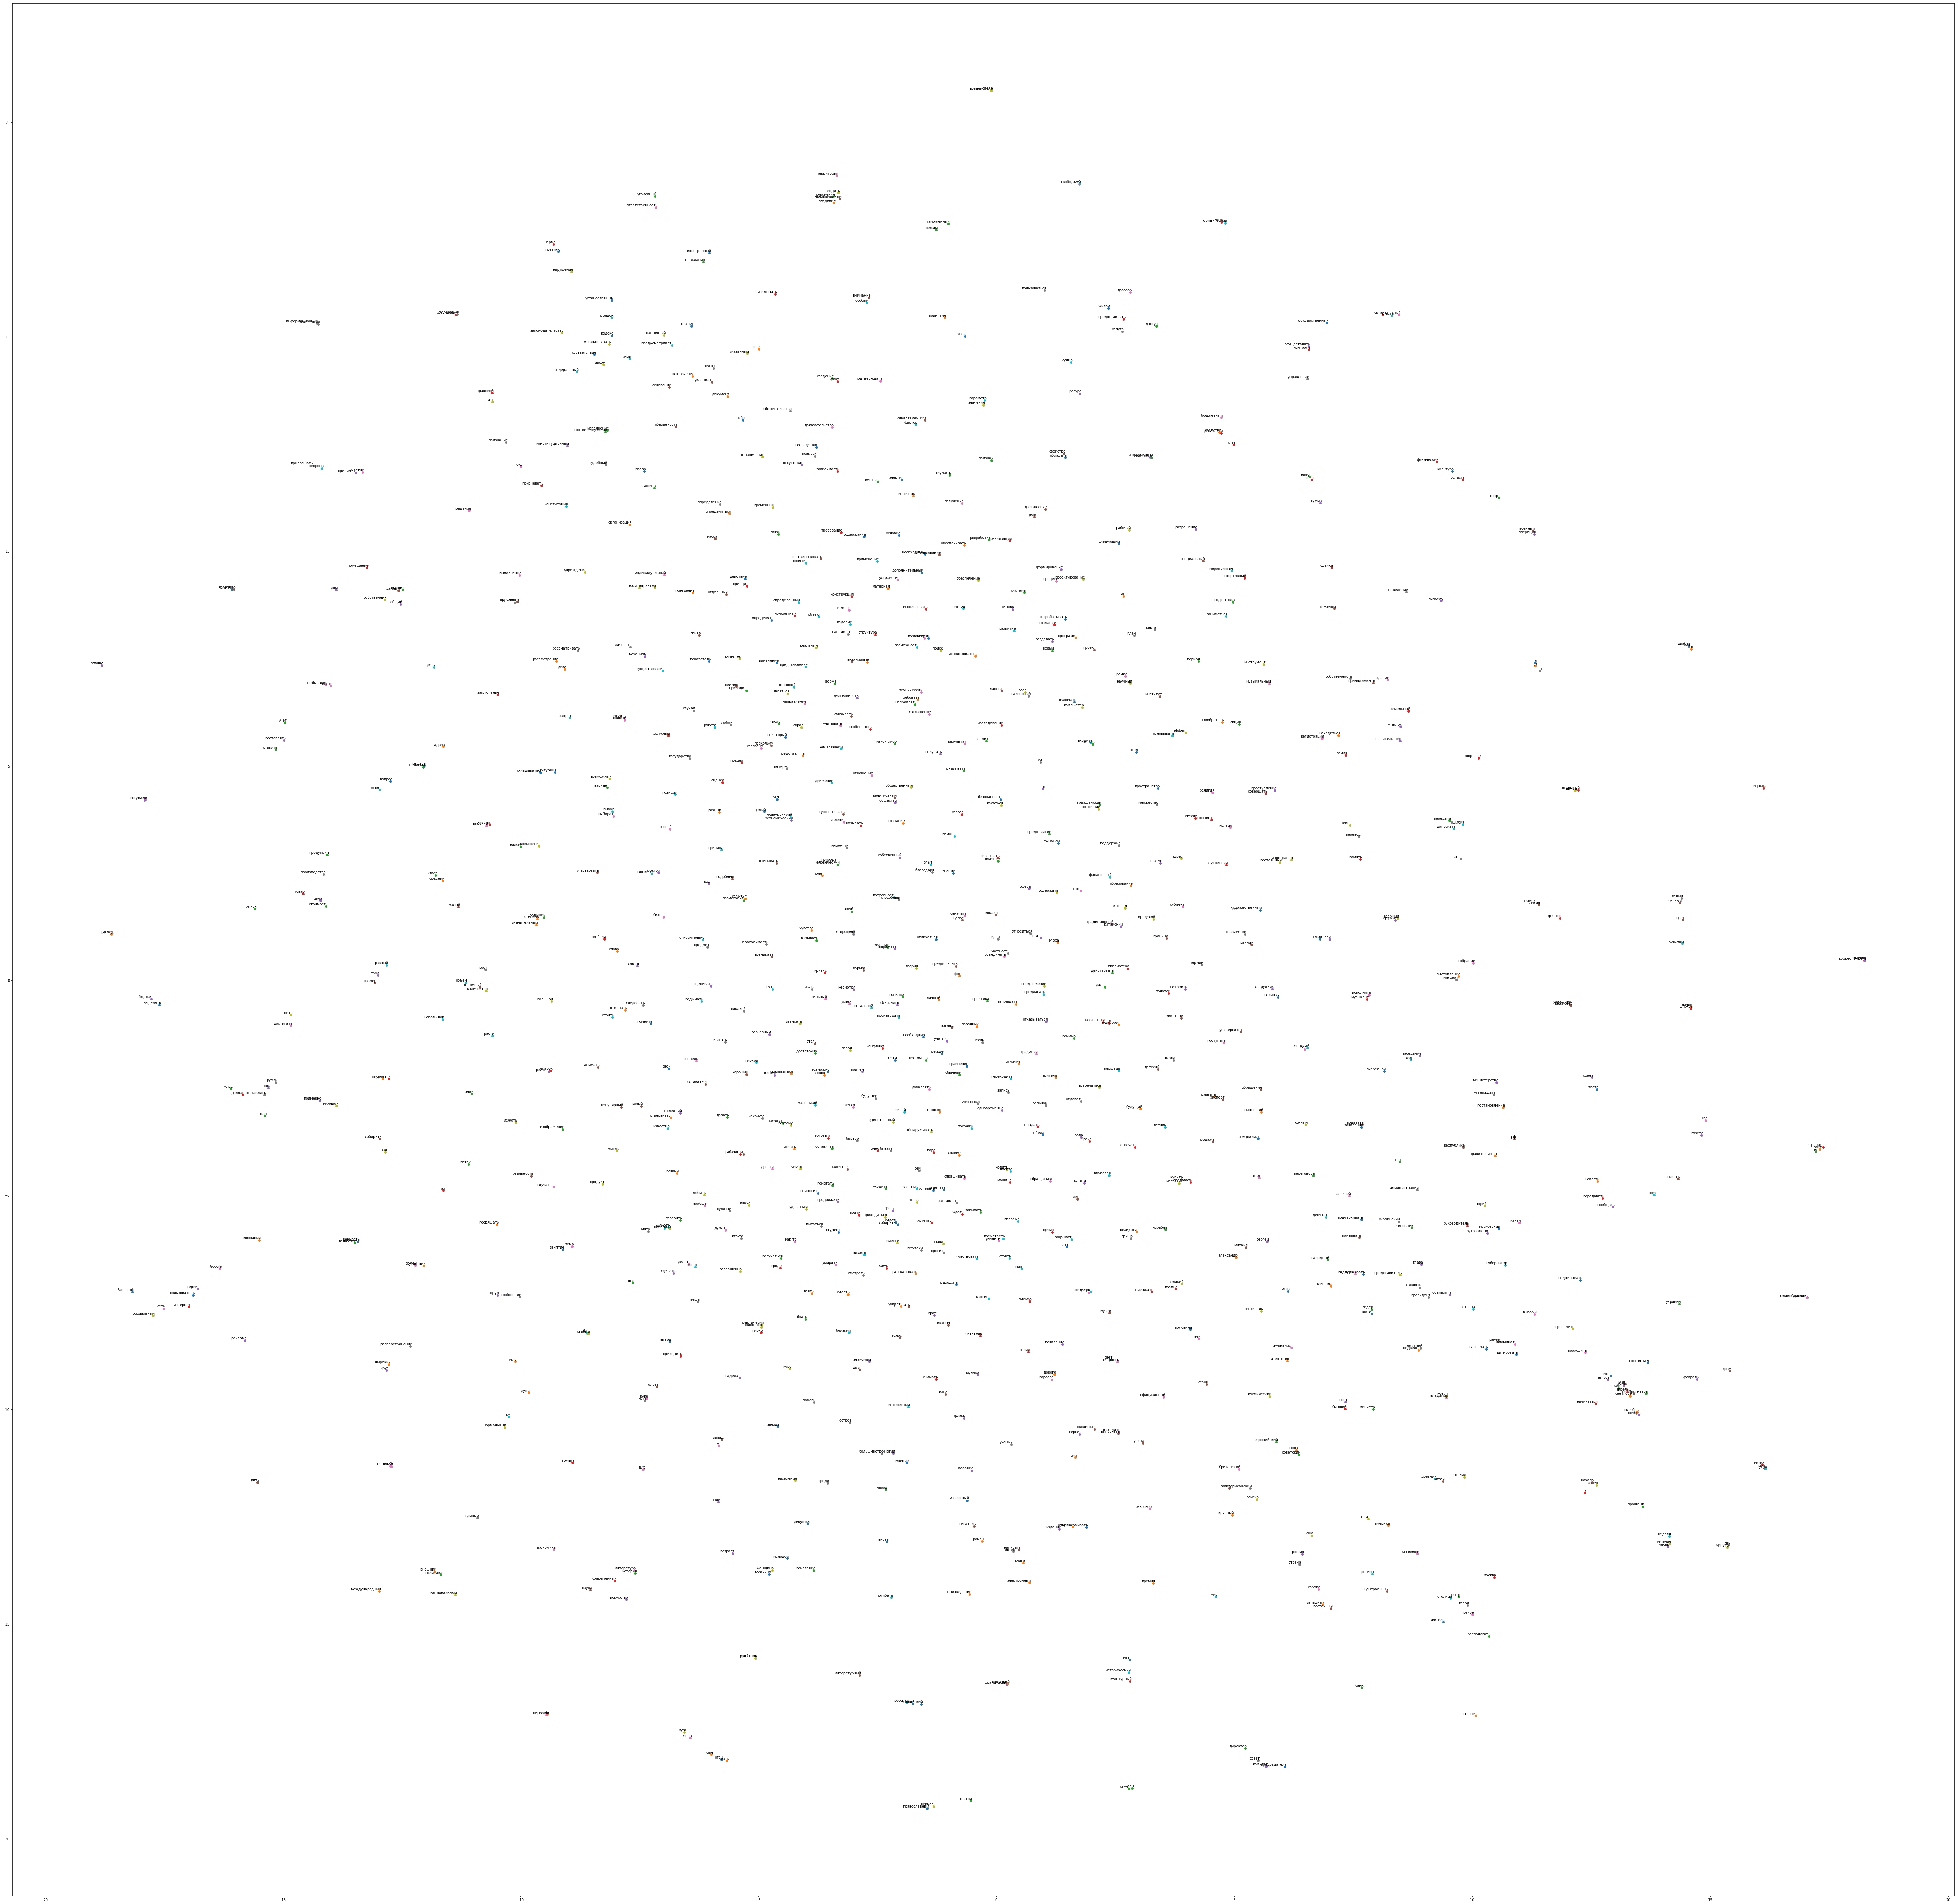

In [7]:
%matplotlib inline
model.generate_tsne()

In [8]:
df = pd.read_csv('data/judicial_orders_lemmas.csv')
code = pd.read_csv('data/criminal_code.csv')
df['lemmas'] = df['lemmas'].map(eval)
code['lemmas'] = code['lemmas'].map(eval)

In [9]:
df['lemmas'] = df['lemmas'].map(lambda lemmas: list(filter(lambda token: token in model.words, lemmas)))

In [10]:
code['lemmas'] = code['lemmas'].map(lambda lemmas: list(filter(lambda token: token in model.words, lemmas)))

In [11]:
def text_embedding(tokens):
    return np.mean(np.array([model.embedding_for(token) for token in tokens]), axis=0)

In [12]:
df['glove'] = df['lemmas'].map(text_embedding)
code['glove'] = code['lemmas'].map(text_embedding)

In [13]:
distances = np.zeros((df.shape[0], code.shape[0]))
for i, text in enumerate(df['glove'].tolist()):
    for j, article in enumerate(code['glove'].tolist()):
        distances[i, j] = cosine(text, article)

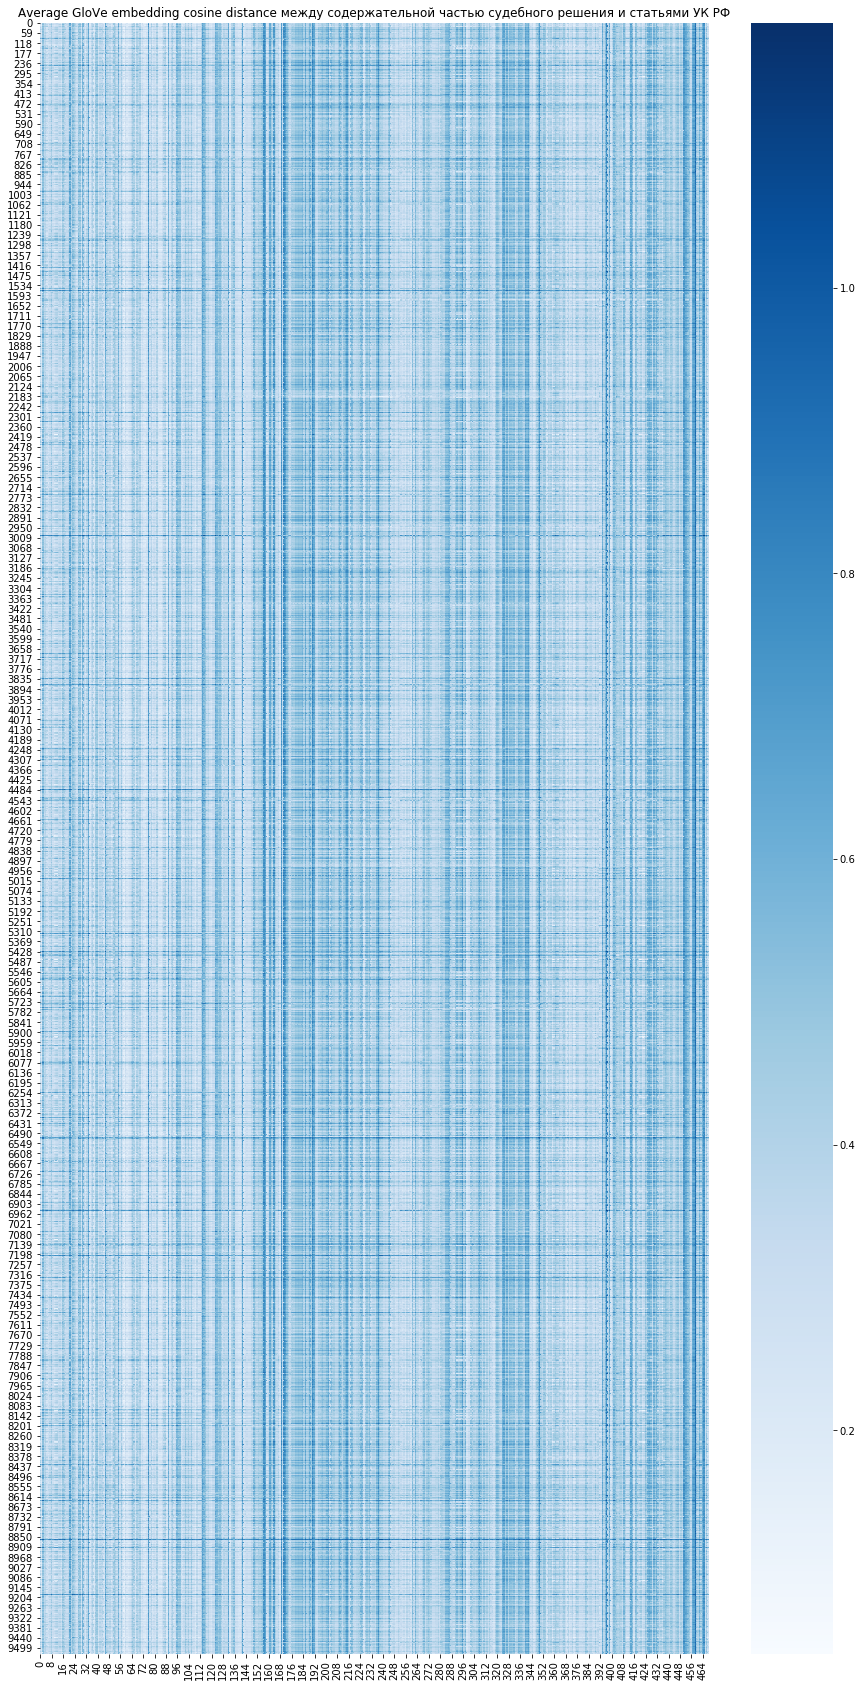

In [14]:
fig, ax = plt.subplots(figsize=(15, 30))
ax.set_title('Average GloVe embedding cosine distance между содержательной частью судебного решения и статьями УК РФ')
ax = sns.heatmap(distances, cmap="Blues", ax=ax)

In [15]:
num_predictions = 5
for i in range(distances.shape[0]):
    df.loc[i, 'predicted'] = str([code.loc[j, 'number'] for j in distances[i].argsort()[:num_predictions]])

df['predicted'] = df['predicted'].map(eval)
df['labels'] = df['labels'].map(eval)

In [16]:
def intersection(row):
    return len(set(row['labels']).intersection(set(row['predicted'])))

df['intersection'] = df.apply(intersection, axis=1)

In [17]:
def has_intersection(row):
    if len(set(row['labels']).intersection(set(row['predicted']))) > 0:
        return 1
    return 0
df['is_right'] = df.apply(has_intersection, axis=1)

In [18]:
df['is_right'].sum() / df.shape[0]

0.09052764082660233

In [19]:
df[['title', 'labels', 'predicted', 'is_right', 'intersection']].to_csv('results/glove.csv', index=False)
df[['title', 'labels', 'predicted', 'is_right', 'intersection']].head(15)

,title,labels,predicted,is_right,intersection
0,Решение по делу 1-14/2018 - 228 ч.2 - судья Ст...,"[228.0, 73.0, 73.0]","[200.3, 230.0, 242.1, 189.0, 242.0]",0,0
1,Решение по делу 1-173/2018 - 159 ч.2 - судья Ш...,"[159.0, 73.0, 72.0]","[61.0, 63.0, 6.0, 122.0, 37.0]",0,0
2,Решение по делу 1-59/2018 - 161 ч.1 - судья Ив...,"[161.0, 317.0]","[61.0, 81.0, 63.0, 96.0, 63.1]",0,0
3,Решение по делу 1-74/2018 - 228 ч.1 - судья Ша...,"[228.0, 317.0]","[61.0, 63.0, 104.2, 2.0, 230.0]",0,0
4,Решение по делу 1-114/2018 - 159 ч.2 - судья Б...,"[159.0, 73.0, 317.0]","[104.2, 122.0, 61.0, 131.0, 63.1]",0,0
5,Решение по делу 1-125/2018 - 159 ч.2 - судья Б...,"[159.0, 317.0]","[189.0, 104.2, 200.3, 184.0, 204.0]",0,0
6,Решение по делу 1-30/2018 - 158 ч.2 п.в - судь...,"[158.0, 81.0, 317.0]","[61.0, 68.0, 82.1, 63.1, 34.0]",0,0
7,Решение по делу 1-31/2018 - 158 ч.3 п.а - судь...,"[158.0, 81.0, 317.0]","[61.0, 81.0, 82.0, 34.0, 68.0]",1,1
8,Решение по делу 1-30/2018 - 228 ч.2 - судья Бо...,[228.0],"[242.1, 63.0, 61.0, 189.0, 230.0]",0,0
9,Решение по делу 1-22/2018 - 228 ч.1 - судья Фи...,"[228.0, 317.0]","[61.0, 63.0, 230.0, 242.1, 189.0]",0,0
